In [1]:
%matplotlib notebook

# 5) IFU line fitting

In this tutorial, we are going to fit the emission lines on the spaxels from the masks, we defined in the [previous tutorial](https://lime-stable.readthedocs.io/en/latest/tutorials/4_IFU_Spatial_Masking.html#).
You can download this tutorial as a [python script](https://github.com/Vital-Fernandez/lime/blob/master/examples/example5_IFU_fitting.py) and a [jupyter notebook](https://github.com/Vital-Fernandez/lime/blob/master/docs/source/tutorials/5_IFU_Line_Fitting.ipynb).


Let’s start by importing the libraries we need:

In [2]:
# This try import is only necessary for the developper to compile the online documentation from this notebook
try:
    import lime
except ImportError:
    import sys
    sys.path.append('../../../src')
    import lime
    
from pathlib import Path
from astropy.io import fits
from astropy.wcs import WCS
from IPython.display import Image, display

Let's define the inputs and outputs paths

In [3]:
# State the data location
cfg_file = Path('./sample_data/manga.cfg')
cube_file = Path('./sample_data/manga-8626-12704-LOGCUBE.fits.gz')
bands_file_0 = Path('./sample_data/SHOC579_MASK0_bands.txt')
spatial_mask_file = Path('./sample_data/SHOC579_mask.fits')
output_lines_log_file = Path('./sample_data/SHOC579_log.fits')

Now we read the observation and treatment configuration

In [4]:
# Load the configuration file:
obs_cfg = lime.load_cfg(cfg_file)

# Observation properties
z_obj = obs_cfg['SHOC579']['redshift']
norm_flux = obs_cfg['SHOC579']['norm_flux']

With this information, we can load the scientific data and define the ``lime.Cube`` object:

In [5]:
# Open the MANGA cube fits file
with fits.open(cube_file) as hdul:
    wave = hdul['WAVE'].data
    flux_cube = hdul['FLUX'].data * norm_flux
    hdr = hdul['FLUX'].header

# Define a LiMe cube object
shoc579 = lime.Cube(wave, flux_cube, redshift=z_obj, norm_flux=norm_flux)

At this point, you have diferent strategies to fit lines on this IFU data set. For example, you can recover the spectrum from a spaxel using the flux cube coordinates.

<div class="alert alert-info">

**Please remember:** This is a [numpy array](https://numpy.org/devdocs/_images/np_matrix_indexing.png), the first and second indeces correspond to the vertical and horizontal axis respectively. These are the spatial axis on an IFU observation. The third index corresponds to the cube depth axis or the IFU wavelength array. The origin in this numerical array is located on the  upper-left-front corner on the 3D array.

</div>

In [6]:
# Extract one spaxel (idx Y, idx X):
spaxel = shoc579.get_spaxel(39, 40)

We can use the ``.fit.frame`` function we visisted in the [3rd tutorial](https://lime-stable.readthedocs.io/en/latest/tutorials/3_CompleteSpectrumFitting.html):

In [7]:
spaxel.fit.frame(bands_file_0, obs_cfg, line_detection=True, obj_ref='MASK_0')

[==========] 100% of 35 lines

The fitted profiles can be displayed using the ``.plot.spectrum`` function:

<IPython.core.display.Javascript object>


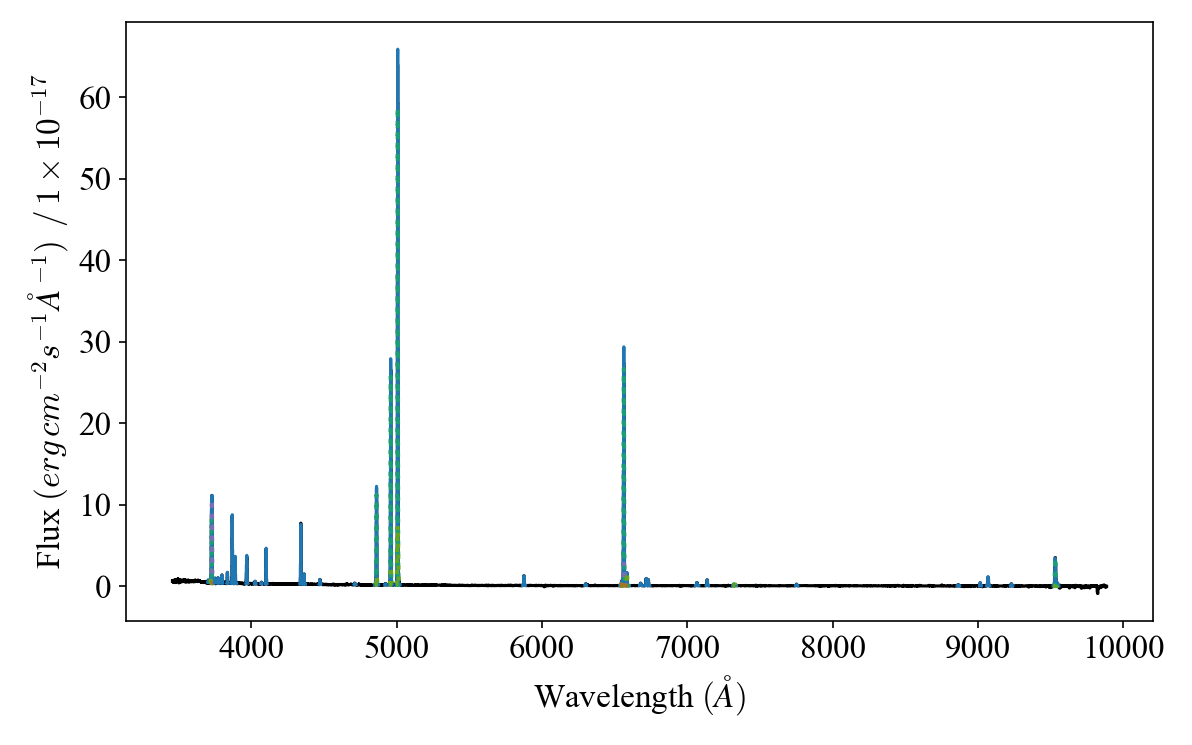

In [8]:
spaxel.plot.spectrum(include_fits=True, rest_frame=True)

To recover the array coordinates from your spatial mask you can use the ``lime.load_spatial_mask``:

In [9]:
masks_dict = lime.load_spatial_mask(spatial_mask_file, return_coords=True)

By default this dictionary contains the mask array (as boolean array) and header for every extension in the input file. However if you set the argument ``return_coords=True`` you will get the array coordinates for every ``True`` value in the spatial mask. You can use this information to analyse the spectra lines:

In [19]:
masks_dict = lime.load_spatial_mask(spatial_mask_file, return_coords=True)
for i, coords in enumerate(masks_dict['MASK_0']):
    print(f'Spaxel {i}) Coordinates {coords}')
    idx_Y, idx_X = coords
    spaxel = shoc579.get_spaxel(idx_Y, idx_Y)
    spaxel.fit.frame(bands_file_0, obs_cfg, line_list=['H1_6563A_b'], obj_ref='MASK_0', plot_fit=False, progress_output=None)

Spaxel 0) Coordinates [35 35]
Spaxel 1) Coordinates [35 36]
Spaxel 2) Coordinates [35 38]
Spaxel 3) Coordinates [35 39]
Spaxel 4) Coordinates [36 35]
Spaxel 5) Coordinates [36 36]
Spaxel 6) Coordinates [36 37]
Spaxel 7) Coordinates [36 38]
Spaxel 8) Coordinates [36 39]
Spaxel 9) Coordinates [36 40]
Spaxel 10) Coordinates [37 35]
Spaxel 11) Coordinates [37 36]
Spaxel 12) Coordinates [37 37]
Spaxel 13) Coordinates [37 38]
Spaxel 14) Coordinates [37 39]
Spaxel 15) Coordinates [37 40]
Spaxel 16) Coordinates [38 34]
Spaxel 17) Coordinates [38 35]
Spaxel 18) Coordinates [38 36]
Spaxel 19) Coordinates [38 37]
Spaxel 20) Coordinates [38 38]
Spaxel 21) Coordinates [38 39]
Spaxel 22) Coordinates [38 40]
Spaxel 23) Coordinates [39 34]
Spaxel 24) Coordinates [39 35]
Spaxel 25) Coordinates [39 36]
Spaxel 26) Coordinates [39 37]
Spaxel 27) Coordinates [39 38]
Spaxel 28) Coordinates [39 39]
Spaxel 29) Coordinates [40 35]
Spaxel 30) Coordinates [40 36]
Spaxel 31) Coordinates [40 37]
Spaxel 32) Coordin

For a more sophisticated analysis you can use the ``.fit.spatial_mask`` function.  To treat serveral spaxels in a efficient workflow, you can use ``.fit.spatial_mask``. This function allows you to fit some or all the masks in the input ``spatial_mask_file``. Moreover, it will save the results into a *.fits* specified in the ``output_log`` parameter. Each page on the output file corresponds to a spaxel. The default page name is **idxY-idxX_LINESLOG**. You can change the default extension suffix with the ``log_ext_suffix='_LINESLOG'`` argument.

In [11]:
# Fit the lines in all the masks spaxels
shoc579.fit.spatial_mask(spatial_mask_file, fit_conf=obs_cfg, line_detection=True, output_log=output_lines_log_file)



Spatial mask 1/3) MASK_0 (33 spaxels)
[==========] 100% of 33 spaxels

Spatial mask 2/3) MASK_1 (97 spaxels)
[==========] 100% of 97 spaxels

Spatial mask 3/3) MASK_2 (97 spaxels)
[========= ] 98% of 97 spaxels

LiMe WARNING: Ne3_3869A failure to measure the non-parametric FWHM


[==========] 100% of 97 spaxels

<div class="alert alert-info">

**Please remember:** The ``.fit.spatial_mask`` function cannot add or update measurements on an existing *.fits* file. It will always overwrite an existing file on the provided ``output_log`` path.

</div>

However, the most import feature from the ``.fit.spatial_mask`` is the posibility to administrate the configuration of your fittings. The image below shows the spatial masks of SHOC579 alongside part of its configuration ``manga.cfg`` file:

![Spatial_configuration_example](../_static/mask_conf_diagram.png)

In these measurements the ``.fit.spatial_mask`` adjust the fitting configuration on three levels:

* At the lowest level, the *[default_line_fitting]* section provides a configuration fitting for all spaxels in all the masks.The name of this section can be modified with the ``default_conf_key="default_line_fitting"`` 
* The *[MASK_0_line_fitting]*, *[MASK_1_line_fitting]* and *[MASK_2_line_fitting]* sections provide the fitting configuration for each corresponding mask. These entries **update** the information from the *[default_line_fitting]*. This means that:
    * In all the masked spaxels ``H1_3889A_m = H1_3889A-He1_3889A`` and ``Ar4_4711A_m = Ar4_4711A-He1_4713A``
    * In `MASK_0` the line ``O2_3726A_b`` has four components while in ``MASK_1`` it only has two
    * Since `MASK_2` does not have any items, the fitting configuration is the same as in *[default_line_fitting]*. Consequently this section can be excluded from the file.
* At the highest level the *[38-35_line_fitting]* section updates the fitting properties of the spaxel on red. Consequently, just in that spaxel ``O3_5007A_b = O3_5007A-O3_5007A_k1-He1_5016A``. Again this entry **updates** the information from the *[MASK_0_line_fitting]* and the *[default_line_fitting]* sections.

We can confirm this configuration by checking this spaxel, the only one with the fitting of the $HeI5016Å$: 

<IPython.core.display.Javascript object>


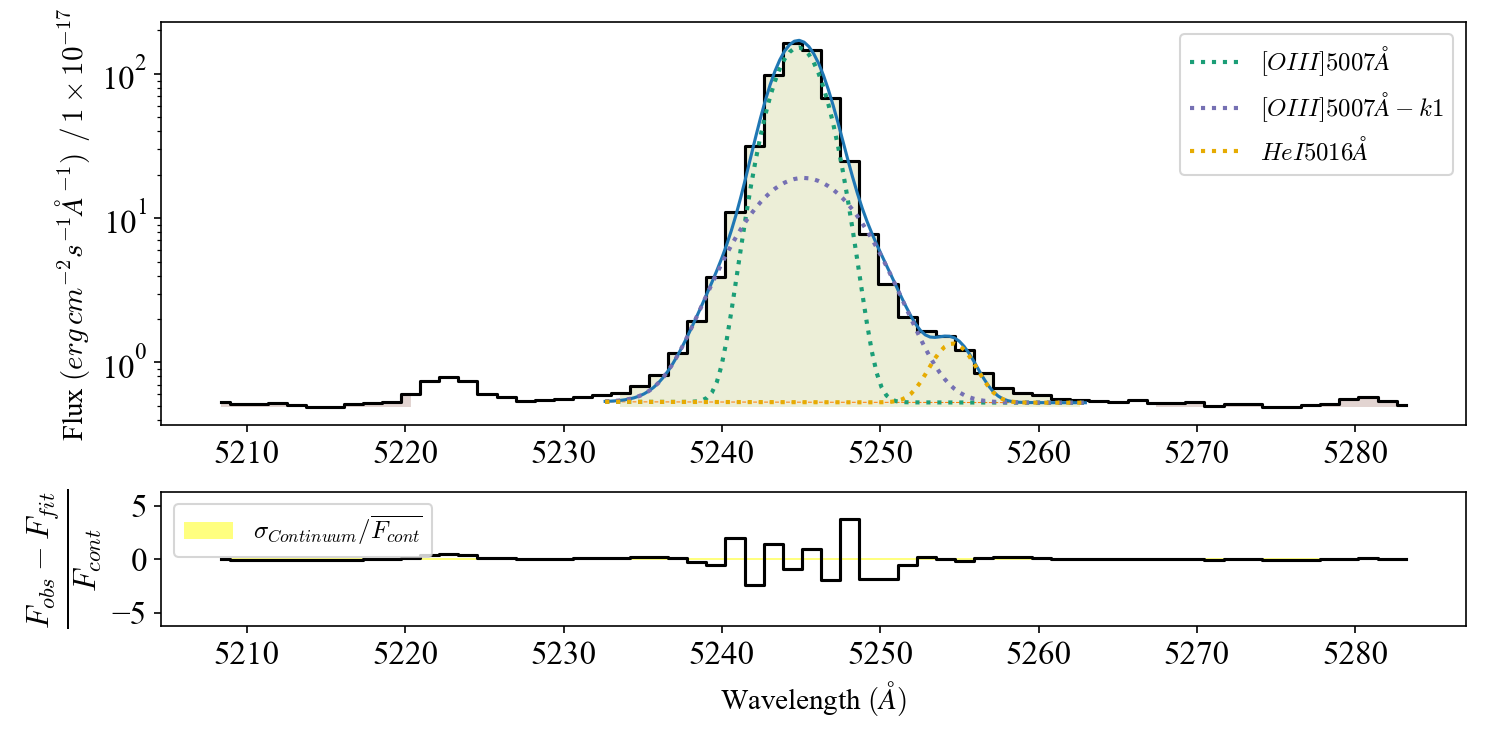

In [17]:
# Check the individual spaxel fitting configuration
spaxel = shoc579.get_spaxel(38, 35)
spaxel.load_log(output_lines_log_file, ext='38-35_LINESLOG')
spaxel.plot.band('He1_5016A')

Additionally, you can adjust the ``.fit.spatial_mask`` measurements with these arguments:

* In the ``mask_name_list=`` you can specify the masks to use from the ``spatial_mask_file`` (the default is all of them).
* The ``fit_conf=obs_cfg`` argument assumes that there are several sections, one for spatial mask, with the **[MASK-NAME_line_fitting]** naming style. Using this formating you can apply a different fitting configuration for each mask. In general you will start with the spaxels with the highest S/N and more complex line profiles and move towards simpler configurations. You can see this on the input [manga.cfg file](https://github.com/Vital-Fernandez/lime/blob/master/examples/sample_data/manga.cfg).
* This function can only save the measurements as a *.fits* file. This file is specified using the ``output_log=output_lines_log_file``. Each page on the *.fits* file corresponds to a spaxel. The default page name is **idxY-idxX_LINESLOG**. You can change the default extension suffix with the ``log_ext_suffix='_LINESLOG'`` argument.
* The ``n_save=100`` argument states after how many spaxels the *.fits* file with the measurements is saved on the hard drive. Additionally, the *.fits* file is always saved at the last spaxel of a mask.

Finally, you can visualize the fitted profiles on the output *.fits* using the ``.plot.cube`` function:

a string value was expected. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


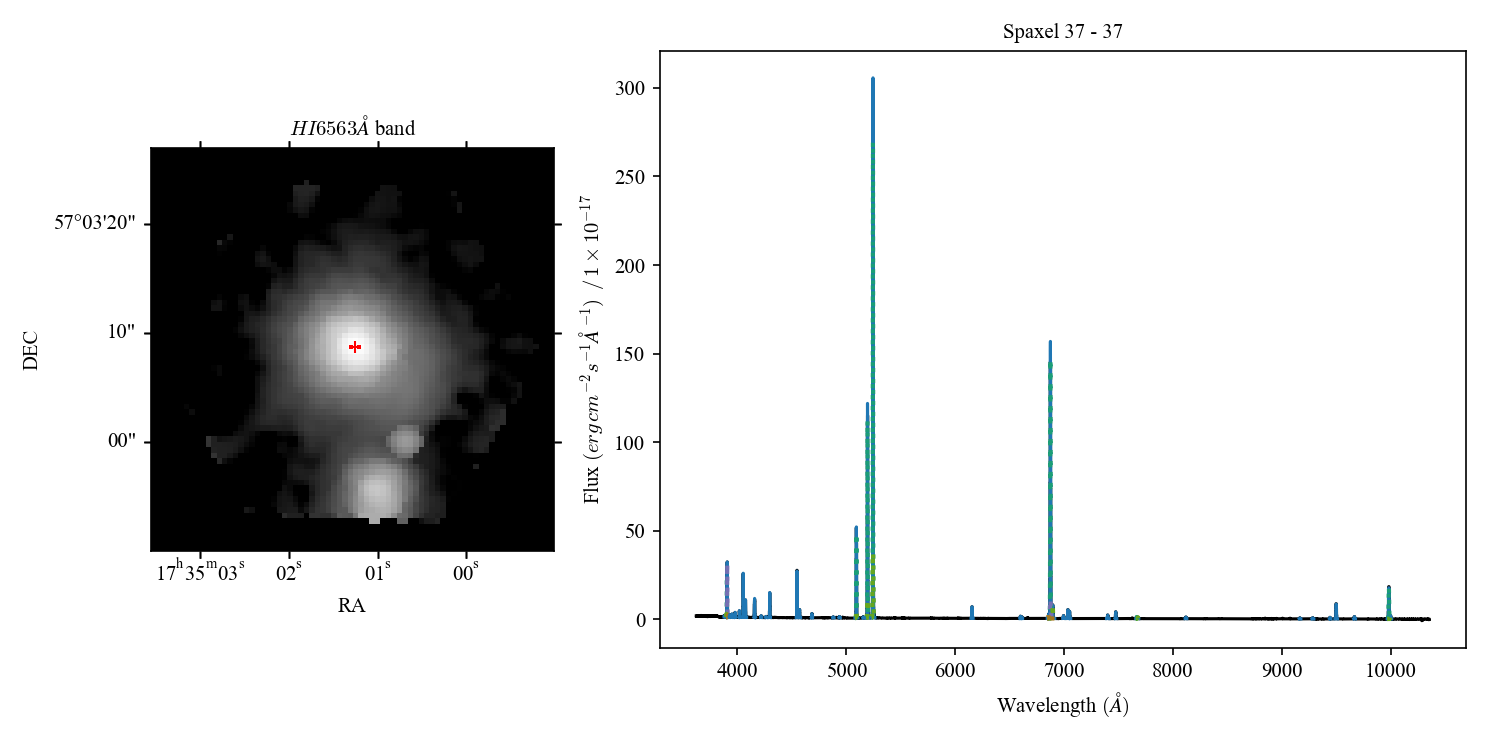

In [12]:
shoc579.check.cube('H1_6563A', wcs=WCS(hdr), lines_log_address=output_lines_log_file)

In the next tutorial, we shall see how you can use $LiMe$ functions to extract the measurements from a spatial lines log such as the one we just generated.